In [ ]:
! pip install tensorflow
! pip install -q kaggle
! pip install keras-preprocessing
! pip install seaborn

In [102]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv("Twitter Sentiment Analysis/Dataset/data.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

Text(0.5, 1.0, 'Target Distribution')

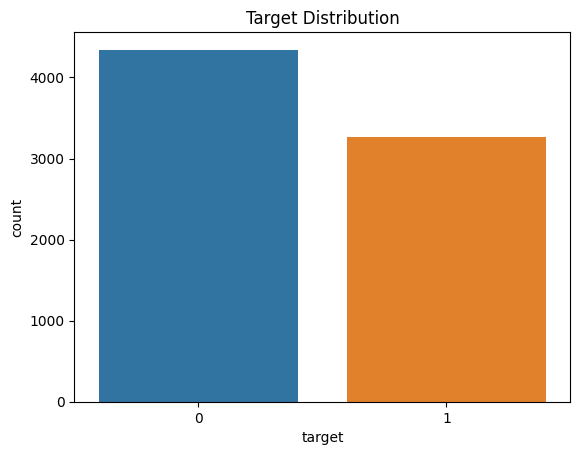

In [9]:
sns.countplot(x='target',data=df)
plt.title('Target Distribution')

## Data Cleaning

In [10]:
df = df.drop(['id', 'keyword', 'location'], axis=1)
df = df.drop_duplicates()

In [11]:
def clean_text(text):
  text = re.sub(r'#', '', text)
  text = re.sub(r'@[-)]+', '', text)
  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  text = re.sub(r'@[A-Za-z]+', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'https?\/\/\S+', '', text)
  text = re.sub(r'&[a-z;]+', '', text)
  text = re.sub(r'[WATCH]', '', text)
  return text

In [12]:
df["text"] = df["text"].apply(clean_text)

In [13]:
df

,text,target
0,Our Deeds are the Reason of this earthquake Ma...,1
1,Forest fire near La Ronge Sask. anada,1
2,ll residents asked to 'shelter in place' are b...,1
3,"13,000 people receive wildfires evacuation ord...",1
4,Just got sent this photo from Ruby laska as sm...,1
...,...,...
7604,orldNews Fallen powerlines on G:link tram: UPD...,1
7605,on the flip side I'm at almart and there is a ...,1
7606,Suicide bomber kills 15 in Saudi security site...,1
7608,wo giant cranes holding a bridge collapse into...,1


In [14]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [15]:
X.head()

,text
0,Our Deeds are the Reason of this earthquake Ma...
1,Forest fire near La Ronge Sask. anada
2,ll residents asked to 'shelter in place' are b...
3,"13,000 people receive wildfires evacuation ord..."
4,Just got sent this photo from Ruby laska as sm...


In [16]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [143]:
X_train,X_test,y_train,y_test = train_test_split(X, y,random_state=0, test_size=0.1, shuffle=True)

## Data Preprocessing

In [144]:
max_vocab = 20000000
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(X_train.iloc[:, 0])

In [146]:
wordidx = tokenizer.word_index
V = len(wordidx)
print("Dataset vocab size =", V)

Dataset vocab size = 20051


In [147]:
train_seq = tokenizer.texts_to_sequences(X_train.iloc[:, 0])
test_seq = tokenizer.texts_to_sequences(X_test.iloc[:, 0])

In [148]:
print("Training Sequence", train_seq[0])
print("Testing Sequence", test_seq[0])

Training Sequence [63, 14, 68, 105, 408, 145, 50, 490, 11, 387, 22]
Testing Sequence [19162, 11085, 11086, 3554, 5393, 2378, 6102, 5, 586, 70, 12, 11087, 3, 1, 2]


In [149]:
train_pad = pad_sequences(train_seq)
test_pad = pad_sequences(test_seq, maxlen=train_pad.shape[1])
print("Length of training sequence:", train_pad.shape[1])
print("Length of testing sequence:", test_pad.shape[1])

Length of training sequence: 33
Length of testing sequence: 33


In [150]:
train_pad[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  63,  14,  68, 105,
       408, 145,  50, 490,  11, 387,  22])

## Model

In [170]:
T = train_pad.shape[1]
D = 20
M = 15

i = Input(shape=(T, ))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.6)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.7)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.7)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(i, x)

In [171]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [172]:
r = model.fit(train_pad, 
              y_train,
              validation_data=(test_pad, y_test), 
              epochs=6)

Epoch 1/6
212/212 [==============================] - 10s 29ms/step - loss: 0.6860 - accuracy: 0.5691 - val_loss: 0.6872 - val_accuracy: 0.5525
Epoch 2/6
212/212 [==============================] - 6s 27ms/step - loss: 0.6810 - accuracy: 0.5762 - val_loss: 0.6804 - val_accuracy: 0.5525
Epoch 3/6
212/212 [==============================] - 6s 29ms/step - loss: 0.6619 - accuracy: 0.6039 - val_loss: 0.6082 - val_accuracy: 0.6946
Epoch 4/6
212/212 [==============================] - 6s 30ms/step - loss: 0.5457 - accuracy: 0.7528 - val_loss: 0.4426 - val_accuracy: 0.8127
Epoch 5/6
212/212 [==============================] - 6s 30ms/step - loss: 0.4122 - accuracy: 0.8437 - val_loss: 0.4689 - val_accuracy: 0.8021
Epoch 6/6
212/212 [==============================] - 6s 30ms/step - loss: 0.3251 - accuracy: 0.8853 - val_loss: 0.5044 - val_accuracy: 0.8061


In [173]:
r.history

{'loss': [0.685990571975708,
  0.6810483932495117,
  0.6618504524230957,
  0.545703113079071,
  0.41223517060279846,
  0.325056791305542],
 'accuracy': [0.5691489577293396,
  0.576241135597229,
  0.6038711667060852,
  0.7528073191642761,
  0.8436761498451233,
  0.8853427767753601],
 'val_loss': [0.6871738433837891,
  0.6804226636886597,
  0.6082491874694824,
  0.44263648986816406,
  0.46889957785606384,
  0.5044289231300354],
 'val_accuracy': [0.5524568557739258,
  0.5524568557739258,
  0.6945551037788391,
  0.8127490282058716,
  0.8021248579025269,
  0.8061088919639587]}

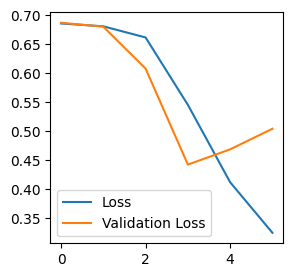

In [174]:
plt.figure(figsize=(3,3))
plt.plot(r.history["loss"], label="Loss")
plt.plot(r.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Prediction

In [175]:
def predict_sentiment(text):
  text_seq = tokenizer.texts_to_sequences(text)
  text_pad = pad_sequences(text_seq, maxlen=T)

  prediction = model.predict(text_pad).round()

  if prediction==1.0:
    print("It is a disaster tweet.")
  else:
    print("It is not a disaster tweet.")


In [176]:
text="What if we used drones to help firefighters lead people out of burning buildings/ help put the fire out?"
predict_sentiment([text])

1/1 [==============================] - 1s 762ms/step
It is a disaster tweet.


In [177]:
text_seq = tokenizer.texts_to_sequences(X_test.iloc[:,0])
text_pad = pad_sequences(text_seq, maxlen=T)
y_pred = model.predict(text_pad).round().astype(int)

24/24 [==============================] - 0s 6ms/step


In [178]:
accuracy_score(y_test, y_pred)

0.8061088977423638